In [45]:
import os
import sys

#### Simple Demo Workflow for Training an OCR Network for Tibetan using Tensorflow

In [6]:
"""
If run from GoogleColab, execute the following in order to clone the Github repo and retrieve the dataset:


user = "OpenPecha"
repo = "TibetanOCR_Tensorflow"

if os.path.isdir(repo):
    !rm -rf {repo}

!git clone https://github.com/{user}/{repo}.git

if not repo in sys.path:
    sys.path.insert(1, repo)

!pip install pyewts


!gdown 1H9UO2Blu4APZE2cqesLQcuNMkFwGcnjK
!unzip -qq /content/KhyentseWangpo.zip -d /home/KhyentseWangpo
"""


  Preparing metadata (setup.py) ... done
  Created wheel for pyewts: filename=pyewts-0.2.0-py3-none-any.whl size=16832 sha256=bd2eca51f24a4c2d3fe875c5c94bdc05faeff258a326e41eb965f25a4b02122b
  Stored in directory: /root/.cache/pip/wheels/88/60/74/963829fa17f8c05336ee8e674ef0c1e32ebe8aa6f7c20dd960
Successfully built pyewts


In [46]:
import json
import random
import pyewts
import tensorflow as tf
from IPython.display import display
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from PIL import Image
from src.Modules import OCRDataset, OCRDataLoader, OCRTrainer
from src.Models import Easter2
from src.Utils import get_charset, decode_image, decode_label
from config import DEFAULT_CHARSET

from IPython.display import Image as ShowImage

In [47]:
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.12.1
[]


Specify the data directory. The assumed structure is:
- dataset_path/lines (for the line images as .jpg)
- dataset_path/transcriptions (for the label files as .txt)

In [48]:
data_root = "Data" # or "/home" if you use Colab
dataset = "KhyentseWangpo"
dataset_path = os.path.join(data_root, dataset)

# converting unicode labels to wylie
converter = pyewts.pyewts()

In [49]:
"""
Use a pre-defined charset or let OCRDataset built one based on the provided labels by leaving charset blank when initializing the OCRDataset.
Note: When running in Google Colab it is advisable to point the output directory of the OCRDataset tht is used for the training checkpoints to a directory in GoogleDrive in case of a disconnection from the runtime.
"""
charset = get_charset(DEFAULT_CHARSET)
# change batch size if necessary, e.g. to 32 in case of OOM errors
batch_size = 32

dataset = OCRDataset(dataset_path, batch_size=batch_size, charset=charset)
train_images, train_labels = dataset.get_train_data()
val_images, val_labels = dataset.get_val_data()

train_loader = OCRDataLoader(train_images, train_labels, batch_size=batch_size, charset=dataset.get_charset(), keep_channel_dim=False)
val_loader = OCRDataLoader(train_images, train_labels, batch_size=batch_size, charset=dataset.get_charset(), keep_channel_dim=False)

INFO:root:Total Images: 13527, Total Labels: 13527
reading labels: 100%|██████████| 13527/13527 [00:14<00:00, 951.27it/s] 
INFO:root:Train Images: 10752
INFO:root:Validation Images: 1344
INFO:root:Test Images: 1344


#### Get one sample from the DataLoader

In [50]:
def show_image(img):
    display(Image.fromarray(img))

(32, 2000, 80)
Label: བཤའ་མར་ཐེབས་པ་ཅིག་བྱ། དེ་ལ་ཐོག་མར་གདམས་ངག་ཁྱད་པར་ཅན་སྟོན་པའི་དགེ་བའི་བཤེས་གཉེན་ཅིག་བཙལ་དགོས་དགོངས་ནས་གསན་པ་འཕྲོ་བཅད་ནས་དབུས་སུ་བྱོན་པའི་ལམ་ཁར་


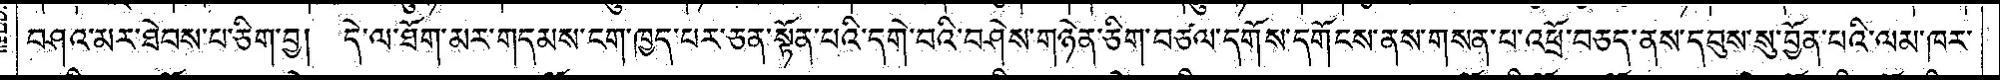

In [51]:
sample = next(iter(train_loader)) # returns a tuple (inputs, outputs), see OCRDataloader

batched_images = sample[0]["images"]
print(batched_images.shape)

batched_labels = sample[0]["labels"]
batch_idx = random.randint(0, batch_size-1)
image = decode_image(batched_images[batch_idx])
label = decode_label(batched_labels[batch_idx], charset, converter)

#print(f"Numeric Label: {batched_labels[batch_idx]}")
print(f"Label: {label}")
show_image(image)

##### Define & train a Easter2 model

In [52]:
tf.keras.backend.clear_session()

model_save_path = f"{dataset.output_dir}/{dataset}_easter.hdf5"
model = Easter2(classes=len(charset))

In [53]:
def lr_scheduler(epoch, lr):
  if epoch < 30:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

In [54]:
epochs = 20 # try 30-40 as a start

callbacks_list = [
                  ModelCheckpoint(filepath=model_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min'),
                  ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-8, verbose=1),
                  LearningRateScheduler(lr_scheduler)
]

history = model.fit(
    train_loader,
    epochs=epochs,
    validation_data=val_loader,
    shuffle=True,
    callbacks=callbacks_list
)

Epoch 1/20
  3/336 [..............................] - ETA: 32:19 - loss: 395.1320

KeyboardInterrupt: 

#### Save Training history and data specs

In [ ]:
# save train history
history_outfile = os.path.join(dataset.output_dir, "train_history.txt")

with open(history_outfile, "w") as f:
    f.write(str(history.history))

In [ ]:
network_config = {
    "input_width" : train_loader.img_width,
    "input_height" : train_loader.img_height,
    "architecture" : "easter2",
    "charset" : dataset.get_charset(),
    "weights_file" : model_save_path
}

out_file = os.path.join(dataset.output_dir, "network_config.json")
json_out = json.dumps(network_config, ensure_ascii=False, indent=2)

with open(out_file, "w", encoding="UTF-8") as f:
    f.write(json_out)

#### Alternatively: Run Training using OCRTrainer class

In [33]:
data_root = "Data" # or /home if in Colab
dataset = "KhyentseWangpo"
charset = get_charset(DEFAULT_CHARSET)

dataset_path = os.path.join(data_root, dataset)

ocr_dataset = OCRDataset(dataset_path, batch_size=32, charset=charset)
ocr_trainer = OCRTrainer(ocr_dataset, model_name="khyentse_wangpo")
trainer_charset = ocr_dataset.get_charset()

INFO:root:Total Images: 3937, Total Labels: 3937
reading labels: 100%|██████████| 3873/3873 [00:02<00:00, 1512.89it/s]
INFO:root:Train Images: 2912
INFO:root:Validation Images: 352
INFO:root:Test Images: 352
INFO:root:Saved model config to: Data\GlomanThang\Output\2023_9_4_11_39\model_config.json


In [ ]:
ocr_trainer.train(epochs=1)

336/336 [==============================] - ETA: 0s - loss: 106.0690
Epoch 1: val_loss improved from inf to 288.20963, saving model to Data/KhyentseWangpo/Output/2023_7_27_10_21/khyentse_wangpo_easter2.hdf5
336/336 [==============================] - 1354s 4s/step - loss: 106.0690 - val_loss: 288.2096 - lr: 0.0010


INFO:root:Finished training of 1 epochs!
